In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
csv_data = pd.read_csv('Index2018.csv')
df_copy = csv_data.copy()
df_copy.date = pd.to_datetime(df_copy.date, dayfirst = True)
df_copy.set_index('date', inplace = True)
df_copy = df_copy.asfreq('b')
df_copy = df_copy.fillna(method = 'ffill')

In [4]:
df_copy['market_value'] = df_copy.ftse
df_copy.head()

spx      dax     ftse    nikkei  market_value
date                                                        
1994-01-07  469.90  2224.95  3445.98  18124.01       3445.98
1994-01-10  475.27  2225.00  3440.58  18443.44       3440.58
1994-01-11  474.13  2228.10  3413.77  18485.25       3413.77
1994-01-12  474.17  2182.06  3372.02  18793.88       3372.02
1994-01-13  472.47  2142.37  3360.01  18577.26       3360.01

In [9]:
for i in df_copy:
    if i != 'market_value':
        del df_copy[i]
    else:
        df_copy.head()
size = int(len(df_copy)*0.8)


In [10]:
df_train, df_test = df_copy.iloc[:size], df_copy.iloc[size:]

# LLR Test

In [11]:
#Función para comparar modelos
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
    

# Creando los retornos

In [13]:
#Los retornos se crean para obtener una serie estacionaria porque la serie de precios no es estacionaria
#Los retornos en este caso es el porcentaje de cambio de un día respecto al anterior
df_train['returns'] = df_train.market_value.pct_change(1)*100
df_train.head()

<ipython-input-13-05c894900e7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['returns'] = df_train.market_value.pct_change(1)*100


market_value   returns
date                              
1994-01-07       3445.98       NaN
1994-01-10       3440.58 -0.156704
1994-01-11       3413.77 -0.779229
1994-01-12       3372.02 -1.222988
1994-01-13       3360.01 -0.356166

# ACF PARA RETORNOS

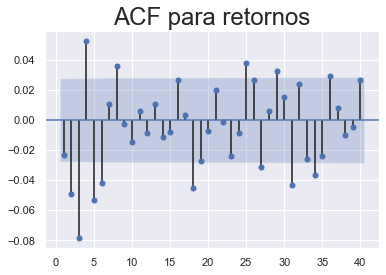

In [16]:
#Pasamos desde la posición 1 porque el primer valor es nan
sgt.plot_acf(df_train.returns[1:], zero = False, lags = 40)
plt.title('ACF para retornos', size = 24)
plt.show()
#Para este caso la función de autocorrelación demuestra que los primeros días son importantes
#además de esto en los negativos la autocorrelación puede indicar que se esta haciendo un ajuste de los precios
#lo cual no es de preocupar si no que es algo que pasa de manera natural en los mercados

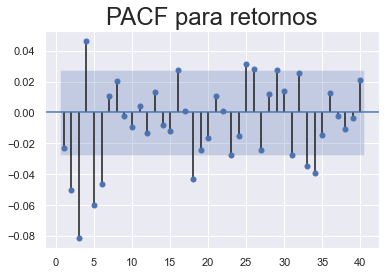

In [18]:
sgt.plot_pacf(df_train.returns[1:], zero = False, lags = 40, method =('ols'))
plt.title('PACF para retornos', size = 24)
plt.show()
#Para este caso las graficas pueden indicar que los precios varian en la dirección opuesta de los precios 
#de ej 1 día.

# MA(1) RETURNS 


In [21]:
#Para este caso tomaremos 1 retraso para la tabla de retornos 
#en el order se pasara como 0 si no queremos tomar valores de AR 
#y en el caso de 1 para un retorno de MA (medias moviles)

model_ret_ma_1 = ARMA(df_train.returns[1:], order = (0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
#Resumen de los resultados
results_ret_ma_1.summary()
#El coeficiente para este caso es del 8%

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Mon, 25 Oct 2021   AIC                          15865.190
Time:                        13:42:57   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8549           +0.0000j           38.8549            0.0000
-----------------------------------------------------------------------------
"""